In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('final_dataset.csv')

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
scaler = StandardScaler()

In [5]:
# CSV 파일을 읽어들입니다.
df = pd.read_csv('final_dataset.csv')

# 특성과 레이블을 분리합니다.
X = df.drop('label', axis=1).values  # 특성 데이터
y = df['label'].values  # 레이블 데이터


# 훈련 세트와 나머지(검증+테스트) 세트로 분할합니다. (80% : 20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train = scaler.fit_transform(X_train)
X_temp = scaler.transform(X_temp)

# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_temp = X_temp.reshape((X_temp.shape[0], 1, X_temp.shape[1]))

# 나머지 데이터를 검증 세트와 테스트 세트로 분할합니다. (50% : 50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 분할된 데이터 세트의 크기를 출력합니다.
print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# 분할된 데이터 세트의 레이블 분포를 출력합니다.
print(f"Train set label distribution: {np.bincount(y_train.astype(int))}")
print(f"Validation set label distribution: {np.bincount(y_val.astype(int))}")
print(f"Test set label distribution: {np.bincount(y_test.astype(int))}")

Train set: 3810 samples
Validation set: 476 samples
Test set: 477 samples
Train set label distribution: [1908 1902]
Validation set label distribution: [238 238]
Test set label distribution: [239 238]


In [6]:
X_train.shape

(3810, 125)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns


Accuracy: 0.9769

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       238
           1       0.97      0.98      0.98       238

    accuracy                           0.98       476
   macro avg       0.98      0.98      0.98       476
weighted avg       0.98      0.98      0.98       476



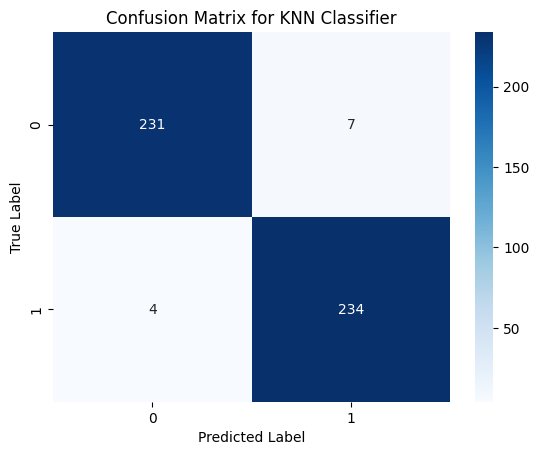

In [14]:
# KNN 모델 구성
knn_classifier = KNeighborsClassifier(n_neighbors=3)  # n_neighbors는 예시로 든 값이며, 실제로는 적절한 값으로 설정해야 합니다.

# 모델 학습
knn_classifier.fit(X_train, y_train)

# 검증 세트를 이용해 예측을 수행합니다.
y_pred = knn_classifier.predict(X_val)

# 정확도를 계산하고 출력합니다.
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 분류 리포트를 생성하고 출력합니다.
class_report = classification_report(y_val, y_pred)
print("\nClassification Report:")
print(class_report)

# 혼동 행렬을 생성하고 시각화합니다.
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN Classifier')
plt.show()